In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model,save_model
from keras.callbacks import ModelCheckpoint
from matplotlib.patches import Rectangle
import os
from scipy.misc import imsave

import keras

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications import xception
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.optimizers import SGD, Adam,Adagrad
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.advanced_activations import LeakyReLU
from math import sqrt
from keras.callbacks import History 
from keras.optimizers import Adam, SGD
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications import xception
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,Input
from keras.layers import BatchNormalization
from keras.models import Model
from keras.activations import relu
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ELU
from math import sqrt
from keras.callbacks import History 
import gc

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# base_dir = '/home/roshansanthosh/Documents/YOLO/YOLO/MultiClass'

base_dir = '/home/rsk/Documents/Projects/YOLO/MultiClass'

In [3]:
from keras.preprocessing import image

def read_img(filepath, size):
    img = image.load_img((filepath), target_size=size)
    img = image.img_to_array(img,data_format='channels_last')
    return img

os.chdir(base_dir + '/25x25/')

X = []

for i in range(8000):
    img = read_img(str(i)+'.png',(25,25))
    X.append(img)

In [4]:


truth = pd.read_csv('25x25_truth.csv')
y = np.array(truth)
y = np.array(y[:,1:])


X= np.array(X)
y = np.array(y)


train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size=25


trainX = X[:7000,:,:,:]
trainy = y[:7000,:]

testX = X[7000:,:,:,:]
testy = y[7000:,:]

train_generator = train_datagen.flow(x=trainX,y=trainy,batch_size=batch_size)
test_generator = test_datagen.flow(x=testX,y=testy,batch_size=batch_size)

[ 3  0  1 16  1  0  6  5  2  3  1  0]


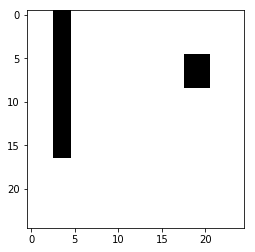

In [5]:
i = 20

plt.imshow(X[i])

print(y[i])

In [6]:
boxLimits = [[0,0,12,25],
             [12,0,25,25]]

In [7]:
'''
    The bb_interesection functions in the earlier test cases varies slightly from this.
    The previous version took 4 arguments : top left x, top left y, bottom right x, bottom right y
    This version takes 4 arguments : top left x, top left y, width, height
    
'''
    
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[0] + boxA[2],boxB[0] + boxB[2])
	yB = min(boxA[1] + boxA[3],boxB[1] + boxB[3])
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
	boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou



def getIoU(model,testData,testTruth,numAnchors = 2,rescale=True):
    
    anchorLength = int(testTruth[0].shape[0]/numAnchors)
 
    
    sample = testData
    if rescale==True:
        sample = testData/255.
    preds = model.predict(sample)
    
    IoUSum = 0.0
    for i in range(len(testTruth)):
        iouTotal = 0.0
        for j in range(0,len(testTruth[i]),anchorLength):
            truth = testTruth[i][j:(j+4)]
            pred  =  preds[i][j:(j+4)]
            iouTotal += bb_intersection_over_union(truth,pred)
        
        IoUSum += iouTotal/numAnchors
    
    meanIoU = IoUSum/len(testTruth)
    
    return(meanIoU)
   

In [6]:
testy[0].shape

(12,)

In [6]:
def cleanFolder(buildNo,keep=5):
    
    os.chdir(base_dir + '/Models')
    fileList = os.listdir('./')
    
    selectFileList = []
    for filename in fileList:
        if str(buildNo) in filename.split("_"):
            selectFileList.append(filename)
            
    a = []
    for i in selectFileList:
        val = float(i[:-5].split("_")[3])
        a.append([val,i])
        
    a = sorted(a,key=lambda x : x[0])
    
    keep = min(keep,len(a))
    
    keepList = [i[1] for i in a[:keep]]
    dropList = [i[1] for i in a[keep:]]
    
    for filename in dropList:
        os.remove(filename)
            
    return(keepList)
 

In [ ]:
def runModel(model,epochs,build=1,optimizer = 'adagrad',keep=5,use_lr=True):
    
        os.chdir(base_dir)
        
        
        sgd = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)
        adam = Adam(lr=2 * 1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
        model.compile(loss='mean_squared_error',optimizer=optimizer,metrics=['mse'])
        hist = History()
        checkPoint = ModelCheckpoint(filepath='./Models/model_'+str(build)+'_{epoch:02d}_{val_loss:.4f}.hdf5',verbose=1,save_best_only=True,mode=min)
#         tensorboard = keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(build), histogram_freq=0, batch_size=25, write_graph=True, write_grads=False, write_images=False)
#         lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=1e-5, patience=3, verbose=1)
    
        if use_lr == True:
            lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=1e-5, patience=3, verbose=1)
            model.fit_generator(train_generator,epochs=epochs,validation_data=test_generator,callbacks = [hist,checkPoint,lr_reduce],verbose=0)
        else:
            model.fit_generator(train_generator,epochs=epochs,validation_data=test_generator,callbacks = [hist,checkPoint],verbose=0)
            
        
        
        keepList = cleanFolder(build,keep=keep)
        
        print("Results")
        
        for filename in keepList:
            print(filename)
            model = load_model(filename)
            epoch = filename.split("_")[2]
            mse = filename.split("_")[3]
            IoU = round(getIoU(model,testX,testy,numAnchors=2),3)
            print("Epoch : {} MSE : {} IoU : {}".format(epoch,mse,IoU))
        
        del model
        del hist
        del checkPoint
#         del tensorboard
        del keepList
        gc.collect()
            
        

## Model Run Iterations

#### Model 1

In [9]:
model = Sequential()
model.add(BatchNormalization(input_shape=(25,25,3)))
model.add(Conv2D(128, (3,3),activation='relu', data_format='channels_last'))

model.add(Dropout(0.3))
model.add(Conv2D(64, (3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(12, activation='linear'))

In [11]:
#Without lr_reduce
runModel(model,epochs=40,build=1,optimizer='adagrad')


Epoch 00001: val_loss improved from inf to 0.08159, saving model to ./Models/model_1_01_0.0816.hdf5

Epoch 00002: val_loss improved from 0.08159 to 0.05857, saving model to ./Models/model_1_02_0.0586.hdf5

Epoch 00003: val_loss improved from 0.05857 to 0.04662, saving model to ./Models/model_1_03_0.0466.hdf5

Epoch 00004: val_loss improved from 0.04662 to 0.04234, saving model to ./Models/model_1_04_0.0423.hdf5

Epoch 00005: val_loss improved from 0.04234 to 0.03985, saving model to ./Models/model_1_05_0.0398.hdf5

Epoch 00006: val_loss improved from 0.03985 to 0.03400, saving model to ./Models/model_1_06_0.0340.hdf5

Epoch 00007: val_loss did not improve

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss improved from 0.03400 to 0.03082, saving model to ./Models/model_1_09_0.0308.hdf5

Epoch 00010: val_loss improved from 0.03082 to 0.02743, saving model to ./Models/model_1_10_0.0274.hdf5

Epoch 00011: val_loss improved from 0.02743 to 0.02727, saving model to ./Models/mode

In [19]:
#With lr_reduce
runModel(model,epochs=40,build=1,optimizer='adagrad')


Epoch 00001: val_loss improved from inf to 0.19356, saving model to ./Models/model_1_01_0.1936.hdf5

Epoch 00002: val_loss improved from 0.19356 to 0.11247, saving model to ./Models/model_1_02_0.1125.hdf5

Epoch 00003: val_loss improved from 0.11247 to 0.05304, saving model to ./Models/model_1_03_0.0530.hdf5

Epoch 00004: val_loss did not improve

Epoch 00005: val_loss improved from 0.05304 to 0.03660, saving model to ./Models/model_1_05_0.0366.hdf5

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss improved from 0.03660 to 0.03470, saving model to ./Models/model_1_07_0.0347.hdf5

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss improved from 0.03470 to 0.03222, saving model to ./Models/model_1_09_0.0322.hdf5

Epoch 00010: val_loss improved from 0.03222 to 0.03164, saving model to ./Models/model_1_10_0.0316.hdf5

Epoch 00011: val_loss improved from 0.03164 to 0.02872, saving model to ./Models/model_1_11_0.0287.hdf5

Epoch 00012: val_loss did not improve

Epoch 0

UnboundLocalError: local variable 'tensorboard' referenced before assignment

#### Model 2

In [12]:
def conv_layer(feature_batch, feature_map, kernel_size=(3, 3),strides=(1,1), zp_flag=False):
    if zp_flag:
        zp = ZeroPadding2D((1,1))(feature_batch)
    else:
        zp = feature_batch
    conv = Conv2D(filters=feature_map, kernel_size=kernel_size, strides=strides)(zp)
    bn = BatchNormalization(axis=3)(conv)
    act = LeakyReLU(1/10)(bn)
    return act

In [35]:
def get_model():
    inp_img = Input(shape=(25, 25, 3))

    # 51
    conv1 = conv_layer(inp_img, 64, zp_flag=False)
    conv2 = conv_layer(conv1, 64, zp_flag=False)
    mp1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)
    # 23
    conv3 = conv_layer(mp1, 128, zp_flag=False)
    conv4 = conv_layer(conv3, 256, zp_flag=False)
    mp2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv4)
    # 9
#     conv7 = conv_layer(mp2, 256, zp_flag=False)
#     conv8 = conv_layer(conv7, 256, zp_flag=False)
#     conv9 = conv_layer(conv8, 256, zp_flag=False)
#     mp3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv9)
    # 1
    # dense layers
    flt = Flatten()(mp2)
#     ds1 = dense_set(flt, 128, activation='tanh')
#     ds2 = dense_set(flt, 64, activation='tanh')
    ds1 = Dense(128, activation='relu')(flt)
    ds2 = Dense(64, activation='relu')(ds1)
    out = Dense(12, activation='linear')(ds1)

    model = Model(inputs=inp_img, outputs=out)
    
  
    return model

In [36]:
model = get_model()

In [37]:
#Without lr_reduce
runModel(model,epochs=40,build=2,optimizer='adagrad',use_lr=False)


Epoch 00001: val_loss improved from inf to 2.93989, saving model to ./Models/model_2_01_2.9399.hdf5

Epoch 00002: val_loss improved from 2.93989 to 0.85498, saving model to ./Models/model_2_02_0.8550.hdf5

Epoch 00003: val_loss improved from 0.85498 to 0.66507, saving model to ./Models/model_2_03_0.6651.hdf5

Epoch 00004: val_loss improved from 0.66507 to 0.49039, saving model to ./Models/model_2_04_0.4904.hdf5

Epoch 00005: val_loss improved from 0.49039 to 0.49036, saving model to ./Models/model_2_05_0.4904.hdf5

Epoch 00006: val_loss improved from 0.49036 to 0.39523, saving model to ./Models/model_2_06_0.3952.hdf5

Epoch 00007: val_loss improved from 0.39523 to 0.23748, saving model to ./Models/model_2_07_0.2375.hdf5

Epoch 00008: val_loss improved from 0.23748 to 0.22092, saving model to ./Models/model_2_08_0.2209.hdf5

Epoch 00009: val_loss improved from 0.22092 to 0.18630, saving model to ./Models/model_2_09_0.1863.hdf5

Epoch 00010: val_loss did not improve

Epoch 00011: val_lo

In [38]:
#With lr_reduce
runModel(model,epochs=50,build=2,optimizer='adagrad',use_lr=True)


Epoch 00001: val_loss improved from inf to 1.53406, saving model to ./Models/model_2_01_1.5341.hdf5

Epoch 00002: val_loss improved from 1.53406 to 0.82706, saving model to ./Models/model_2_02_0.8271.hdf5

Epoch 00003: val_loss improved from 0.82706 to 0.35821, saving model to ./Models/model_2_03_0.3582.hdf5

Epoch 00004: val_loss improved from 0.35821 to 0.16510, saving model to ./Models/model_2_04_0.1651.hdf5

Epoch 00005: val_loss did not improve

Epoch 00006: val_loss improved from 0.16510 to 0.09787, saving model to ./Models/model_2_06_0.0979.hdf5

Epoch 00007: val_loss did not improve

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss improved from 0.09787 to 0.07281, saving model to ./Models/model_2_09_0.0728.hdf5

Epoch 00010: val_loss did not improve

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss did not improve

Epoch 00013: val_loss did not improve

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.000999999977648.

Epoch 00014: val_loss i

In [39]:
#With lr_reduce
runModel(model,epochs=50,build=2,optimizer='adadelta',use_lr=True)


Epoch 00001: val_loss improved from inf to 1.37729, saving model to ./Models/model_2_01_1.3773.hdf5

Epoch 00002: val_loss improved from 1.37729 to 0.68811, saving model to ./Models/model_2_02_0.6881.hdf5

Epoch 00003: val_loss improved from 0.68811 to 0.48844, saving model to ./Models/model_2_03_0.4884.hdf5

Epoch 00004: val_loss did not improve

Epoch 00005: val_loss did not improve

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss did not improve

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.1.

Epoch 00008: val_loss improved from 0.48844 to 0.11047, saving model to ./Models/model_2_08_0.1105.hdf5

Epoch 00009: val_loss improved from 0.11047 to 0.05133, saving model to ./Models/model_2_09_0.0513.hdf5

Epoch 00010: val_loss improved from 0.05133 to 0.04623, saving model to ./Models/model_2_10_0.0462.hdf5

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss did not improve

Epoch 00013: val_loss did not improve

Epoch 00014: val_loss did not improve

#### Model 3

In [13]:
def get_model():
    inp_img = Input(shape=(25, 25, 3))

    # 51
    conv1 = conv_layer(inp_img, 64, zp_flag=False)
    conv2 = conv_layer(conv1, 128, zp_flag=False)
    mp1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)
    # 23
    conv3 = conv_layer(mp1, 128, zp_flag=False)
    conv4 = conv_layer(conv3, 256, zp_flag=False)
    mp2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv4)
    # 9
#     conv7 = conv_layer(mp2, 256, zp_flag=False)
#     conv8 = conv_layer(conv7, 256, zp_flag=False)
#     conv9 = conv_layer(conv8, 256, zp_flag=False)
#     mp3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv9)
    # 1
    # dense layers
    flt = Flatten()(mp2)
#     ds1 = dense_set(flt, 128, activation='tanh')
#     ds2 = dense_set(flt, 64, activation='tanh')
    ds1 = Dense(256, activation='relu')(flt)
    ds2 = Dense(32, activation='relu')(ds1)
    out = Dense(12, activation='linear')(ds1)

    model = Model(inputs=inp_img, outputs=out)
    
  
    return model

In [14]:
model=get_model()

In [21]:
#With lr_reduce
runModel(model,epochs=70,build=3,optimizer='adadelta',use_lr=True)

/home/roshansanthosh/.local/lib/python3.6/site-packages/keras/callbacks.py:405: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)
/home/roshansanthosh/.local/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '



Epoch 00001: val_loss improved from inf to 7.30242, saving model to ./Models/model_3_01_7.3024.hdf5

Epoch 00002: val_loss improved from 7.30242 to 1.08938, saving model to ./Models/model_3_02_1.0894.hdf5

Epoch 00003: val_loss improved from 1.08938 to 0.40144, saving model to ./Models/model_3_03_0.4014.hdf5

Epoch 00004: val_loss did not improve from 0.40144

Epoch 00005: val_loss improved from 0.40144 to 0.09833, saving model to ./Models/model_3_05_0.0983.hdf5

Epoch 00006: val_loss did not improve from 0.09833

Epoch 00007: val_loss did not improve from 0.09833

Epoch 00008: val_loss did not improve from 0.09833

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00009: val_loss improved from 0.09833 to 0.02809, saving model to ./Models/model_3_09_0.0281.hdf5

Epoch 00010: val_loss improved from 0.02809 to 0.01601, saving model to ./Models/model_3_10_0.0160.hdf5

Epoch 00011: val_loss improved from 0.01601 to 0.01525, saving model to ./Models/mo

#### Model 4

In [48]:
def get_model():
    inp_img = Input(shape=(25, 25, 3))

    # 51
    conv1 = conv_layer(inp_img, 256, zp_flag=False)
    conv2 = conv_layer(conv1, 128, zp_flag=False)
    mp1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)
    # 23
    conv3 = conv_layer(mp1, 128, zp_flag=False)
    conv4 = conv_layer(conv3, 64, zp_flag=False)
    mp2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv4)
    # 9
#     conv7 = conv_layer(mp2, 256, zp_flag=False)
#     conv8 = conv_layer(conv7, 256, zp_flag=False)
#     conv9 = conv_layer(conv8, 256, zp_flag=False)
#     mp3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv9)
    # 1
    # dense layers
    flt = Flatten()(mp2)
#     ds1 = dense_set(flt, 128, activation='tanh')
#     ds2 = dense_set(flt, 64, activation='tanh')
    ds1 = Dense(256, activation='relu')(flt)
    ds2 = Dense(32, activation='relu')(ds1)
    out = Dense(12, activation='linear')(ds1)

    model = Model(inputs=inp_img, outputs=out)
    
  
    return model

In [49]:
model=get_model()

In [50]:
#With lr_reduce
runModel(model,epochs=50,build=4,optimizer='adadelta',use_lr=True)


Epoch 00001: val_loss improved from inf to 4.27731, saving model to ./Models/model_4_01_4.2773.hdf5

Epoch 00002: val_loss did not improve

Epoch 00003: val_loss did not improve

Epoch 00004: val_loss did not improve

Epoch 00005: val_loss improved from 4.27731 to 3.54924, saving model to ./Models/model_4_05_3.5492.hdf5

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss improved from 3.54924 to 2.22029, saving model to ./Models/model_4_07_2.2203.hdf5

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss did not improve

Epoch 00010: val_loss improved from 2.22029 to 0.89899, saving model to ./Models/model_4_10_0.8990.hdf5

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss improved from 0.89899 to 0.83516, saving model to ./Models/model_4_12_0.8352.hdf5

Epoch 00013: val_loss did not improve

Epoch 00014: val_loss improved from 0.83516 to 0.24244, saving model to ./Models/model_4_14_0.2424.hdf5

Epoch 00015: val_loss did not improve

Epoch 00016: val_loss 

In [52]:
#With adam hardcoded
runModel(model,epochs=50,build=4,optimizer='adadelta',use_lr=True)


Epoch 00001: val_loss improved from inf to 2.06662, saving model to ./Models/model_4_01_2.0666.hdf5

Epoch 00002: val_loss did not improve

Epoch 00003: val_loss did not improve

Epoch 00004: val_loss did not improve

Epoch 00005: val_loss improved from 2.06662 to 0.68695, saving model to ./Models/model_4_05_0.6870.hdf5

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss did not improve

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss improved from 0.68695 to 0.49931, saving model to ./Models/model_4_09_0.4993.hdf5

Epoch 00010: val_loss did not improve

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss did not improve

Epoch 00013: val_loss did not improve

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.000200000009499.

Epoch 00014: val_loss improved from 0.49931 to 0.02366, saving model to ./Models/model_4_14_0.0237.hdf5

Epoch 00015: val_loss improved from 0.02366 to 0.01723, saving model to ./Models/model_4_15_0.0172.hdf5

Epoch 00016

#### Resnet

### Testing

In [8]:
model = load_model('/home/rsk/Documents/Projects/YOLO/MultiClass/Models/model_4_25_0.0106.hdf5')

In [9]:
model1 = load_model('/home/rsk/Documents/Projects/YOLO/MultiClass/Models/model_2_30_0.0314.hdf5')

In [10]:
numAnchors=2
anchorLength=6

boxLimits = [[0,0,12,25],
             [12,0,25,25]]

In [11]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [12]:
def  addRect(anchorLength,boxLimits,pred,color='blue'):
    
    rectList = []
    
    for k in range(len(boxLimits)):
        box = boxLimits[k]
        predBox = pred[0][k*anchorLength:(k*anchorLength+4)]
        predBoxClass = pred[0][k*anchorLength+4:(k*anchorLength+6)]
        
        if predBoxClass[0]> predBoxClass[1]:
            color='blue'
        else:
            color ='red'
  
        rect = Rectangle((predBox[0]+box[0]-0.5,predBox[1]+box[1]-0.5),predBox[2]+1, predBox[3]+1,fill=False,edgecolor=color,
                     linewidth=2)
        rectList.append(rect)
        
    return(rectList)

In [13]:
def getLabelProb(pred,truth):
    
    softmax_results = []
    
    for k in range(len(boxLimits)):
        anchor_pred = pred[0][(k*anchorLength+4): (k*anchorLength+6) ]
        print(anchor_pred)
        truth_pred = truth[0][(k*anchorLength+4): (k*anchorLength+6) ]
        
        result = softmax(anchor_pred)
        
        predLabel = np.argmax(result)
        truthLabel = np.argmax(truth_pred)
        
        softmax_results.append(result)
        
    return(softmax_results)

In [14]:
def testSample(obs,modelList,numAnchors = 2):
    
    if obs>=len(testX):
        print("Out of bounds")
        
    sample = testX[obs]
    
    sample = sample.reshape((1,25,25,3))
    sample = sample/255.
    truth = [testy[obs]]
    
    IoU1 = getIoU(modelList[0][0], sample, truth,rescale=False)
    IoU2 = getIoU(modelList[1][0], sample, truth,rescale=False)
    
    pred1 = modelList[0][0].predict(sample)
    pred2 = modelList[1][0].predict(sample)
    
    
    softmax1 = getLabelProb(pred1,truth)
    softmax2 = getLabelProb(pred2,truth)
    
    factor=0.2
    matplotlib.rcParams['figure.figsize'] = [40*factor,75*factor]
    
    
    fig,ax = plt.subplots(1)
    
    ax.imshow(sample[0,:,:,:])
    
    rectList1 = addRect(anchorLength,boxLimits,pred1,modelList[0][1])
    rectList2 = addRect(anchorLength,boxLimits,pred2,modelList[1][1])
    
    for rec in rectList1:
        ax.add_patch(rec)
    for rec in rectList2:
        ax.add_patch(rec)
        

    
    print("Truth : {}".format(truth[0]))
    print("Pred1 : {}".format(pred1))
    print("Pred2 : {}".format(pred2))
    
    print("IoU1 : {} IoU2 : {}".format(IoU1,IoU2))
    print("Softmax Label 1 : {}".format(softmax1))
    print("Softmax Label 2 : {}".format(softmax2))
    
    plt.show()
    

[-0.01303518  1.0101451 ]
[ 1.0228567  -0.02027929]
[0.02493751 1.0983742 ]
[0.8726274  0.05090879]
Truth : [ 7  1  4  4  0  1  8  2  3 16  1  0]
Pred1 : [[ 6.9415421e+00  9.9285376e-01  4.1061721e+00  4.0263219e+00
  -1.3035178e-02  1.0101451e+00  7.8868227e+00  1.9874225e+00
   3.0137141e+00  1.5910894e+01  1.0228567e+00 -2.0279288e-02]]
Pred2 : [[ 6.861466    1.1331781   4.0214953   4.1073804   0.02493751  1.0983742
   7.8818426   1.525068    3.1945374  16.549389    0.8726274   0.05090879]]
IoU1 : 0.958092242834 IoU2 : 0.903896053935
Softmax Label 1 : [array([0.26440838, 0.7355916 ], dtype=float32), array([0.7394546 , 0.26054534], dtype=float32)]
Softmax Label 2 : [array([0.25475007, 0.7452499 ], dtype=float32), array([0.69460106, 0.305399  ], dtype=float32)]


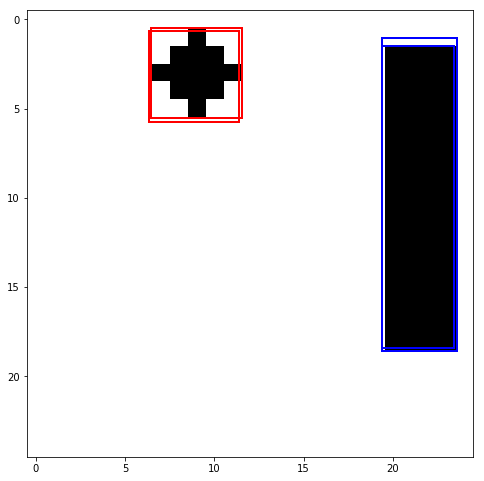

In [15]:
testSample(45,[[model,'red'],[model1,'blue']])


### VideoFrame Testing

In [5]:
def testSample2(filename,modelList,numAnchors = 2):
    
  
    sample = read_img(filename,(25,25))
    
    sample = sample.reshape((1,25,25,3))
    sample = sample/255.
    
    pred1 = modelList[0][0].predict(sample)
    
    factor=0.2
    matplotlib.rcParams['figure.figsize'] = [40*factor,75*factor]
    
    
    fig,ax = plt.subplots(1)
    
    ax.imshow(sample[0,:,:,:])
    
    rectList1 = addRect(anchorLength,boxLimits,pred1,modelList[0][1])
    
    
    for rec in rectList1:
        ax.add_patch(rec)
        

    return(fig)
    

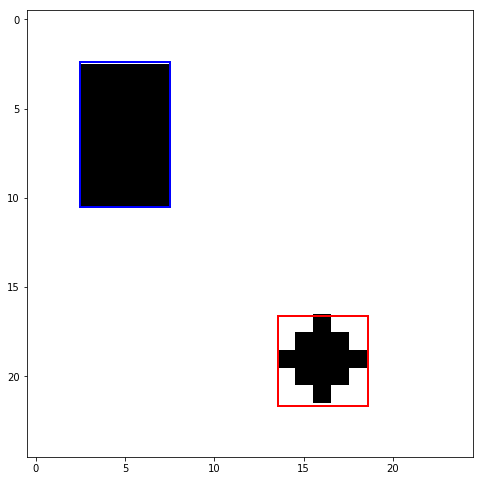

In [7]:
e = testSample2('/home/rsk/Documents/Projects/YOLO/MultiClass/VideoImageFolder/img56.png',[[model,'blue']])

In [9]:
os.chdir("/home/rsk/Documents/Projects/YOLO/MultiClass/VideoImageFolderPreds")

for i in range(1500,2000):
    filename = '/home/rsk/Documents/Projects/YOLO/MultiClass/VideoImageFolder/img'+str(i)+'.png'
    
    pred = testSample2(filename,[[model,'blue']])
    print(i)
    
    pred.savefig('pred'+str(i)+'.png')
    
    plt.close(pred)
    
    
    
    
    

1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
